In [37]:
import cv2
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from skimage import restoration
from sklearn.cluster import KMeans
from sklearn.linear_model import RANSACRegressor


np.set_printoptions(threshold=sys.maxsize)    

In [38]:
## Helper funcions
def load_and_convert_image(image_path):
    """Load image and convert to grayscale"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found or could not be loaded. Check the file path.")
    print(f"Image loaded successfully. Shape: {img.shape}, dtype: {img.dtype}")
    return img

def invert_image(img):
    """Invert image colors"""
    img_inv = cv2.bitwise_not(img)
    return img_inv

def apply_blur(img, kernel_size=(3,3)):
    """Apply blur to image"""
    return cv2.blur(img, kernel_size)

def subtract_background(img, radius=25):
    """Subtract background using rolling ball algorithm"""
    background = restoration.rolling_ball(img, radius=radius)
    return img - background

def apply_thresholding(img, dot_diameter):
    """Apply adaptive thresholding to binarize image"""
    block_size = int(dot_diameter * 2) + 1  # Ensure odd number
    return cv2.adaptiveThreshold(img, 255, 
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, block_size, 2)

def apply_morphological_cleanup(thresh_img):
    """Clean up image using morphological operations"""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    return cv2.morphologyEx(thresh_img, cv2.MORPH_CLOSE, kernel)

def show_image(img, title="Image", cmap='gray', figsize=(8, 8)):
    """Helper function to display an image"""
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def create_results_dataframe(results):
    """Create and normalize results dataframe"""
    df = pd.DataFrame(results)
    if len(df) > 0:
        df['normalized_density'] = df.integrated_density / df.integrated_density.max()
    else:
        df['normalized_density'] = np.nan
    return df

In [39]:
## Grid Detection Functions
def detect_grid_lines(binary_img, expected_rows=14, expected_cols=26, min_distance=8, smoothing_window=5, regularize_peaks=False, debug=False):
    """
    Detect grid lines using projection profiles
    
    Parameters:
    -----------
    binary_img : numpy.ndarray
        Binary image with dots (white) on background (black)
    expected_rows : int
        Expected number of rows in the grid
    expected_cols : int
        Expected number of columns in the grid
    min_distance : int
        Minimum distance between peaks (grid lines)
    smoothing_window : int
        Window sie for smoothing projection profiles
    debug : bool
        If True, show debug visualizations
        
    Returns:
    --------
    row_peaks : numpy.ndarray
        Y-coordinates of detected row centers
    col_peaks : numpy.ndarray
        X-coordinates of detected column centers
    """
    # Calculate projection profiles
    row_profile = np.sum(binary_img, axis=1)  # Sum across rows (horizontal projection)
    col_profile = np.sum(binary_img, axis=0)  # Sum across columns (vertical projection)
    
    # Smooth the profiles to reduce noise
    from scipy.signal import savgol_filter
    if len(row_profile) > smoothing_window:
        row_profile_smooth = savgol_filter(row_profile, smoothing_window, 3)
        col_profile_smooth = savgol_filter(col_profile, smoothing_window, 3)
    else:
        row_profile_smooth = row_profile
        col_profile_smooth = col_profile
    
    # Detect peaks in the profiles
    from scipy.signal import find_peaks
    row_peaks, _ = find_peaks(row_profile_smooth, distance=min_distance)
    col_peaks, _ = find_peaks(col_profile_smooth, distance=min_distance)

    
    if regularize_peaks:
        row_peaks = regularize_peaks(row_peaks, expected_rows)
        col_peaks = regularize_peaks(col_peaks, expected_cols)

    # Ensure we have exactly the expected number of peaks
    row_peaks = np.sort(row_peaks)[:expected_rows]
    col_peaks = np.sort(col_peaks)[:expected_cols]
    
    
    # If too many or too few peaks are found, try adaptive thresholding
    if len(row_peaks) < expected_rows or len(row_peaks) > expected_rows * 1.5:
        # Sort peaks by prominence and take the top expected_rows
        row_peaks, properties = find_peaks(row_profile_smooth, distance=min_distance, height=0)
        if len(row_peaks) >= expected_rows:
            # Sort by peak height
            sorted_indices = np.argsort(-properties["peak_heights"])
            row_peaks = row_peaks[sorted_indices[:expected_rows]]
            row_peaks = np.sort(row_peaks)  # Sort by position again
    
    if len(col_peaks) < expected_cols or len(col_peaks) > expected_cols * 1.5:
        # Sort peaks by prominence and take the top expected_cols
        col_peaks, properties = find_peaks(col_profile_smooth, distance=min_distance, height=0)
        if len(col_peaks) >= expected_cols:
            # Sort by peak height
            sorted_indices = np.argsort(-properties["peak_heights"])
            col_peaks = col_peaks[sorted_indices[:expected_cols]]
            col_peaks = np.sort(col_peaks)  # Sort by position again

    
    if debug:
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        
        # Show horizontal projection profile
        axs[0, 0].plot(row_profile)
        axs[0, 0].plot(row_profile_smooth, 'r-')
        axs[0, 0].plot(row_peaks, row_profile_smooth[row_peaks], 'go')
        axs[0, 0].set_title(f"Horizontal Projection (Detected {len(row_peaks)} rows)")
        axs[0, 0].set_xlabel("Row Index")
        axs[0, 0].set_ylabel("Sum of Pixels")
        
        # Show vertical projection profile
        axs[0, 1].plot(col_profile)
        axs[0, 1].plot(col_profile_smooth, 'r-')
        axs[0, 1].plot(col_peaks, col_profile_smooth[col_peaks], 'go')
        axs[0, 1].set_title(f"Vertical Projection (Detected {len(col_peaks)} columns)")
        axs[0, 1].set_xlabel("Column Index")
        axs[0, 1].set_ylabel("Sum of Pixels")
        
        # Show the image with row lines
        axs[1, 0].imshow(binary_img, cmap='gray')
        for peak in row_peaks:
            axs[1, 0].axhline(y=peak, color='r', linewidth=1)
        axs[1, 0].set_title("Detected Row Lines")
        
        # Show the image with column lines
        axs[1, 1].imshow(binary_img, cmap='gray')
        for peak in col_peaks:
            axs[1, 1].axvline(x=peak, color='b', linewidth=1)
        axs[1, 1].set_title("Detected Column Lines")
        
        plt.tight_layout()
        plt.show()

    
    
    return row_peaks, col_peaks

def regularize_peaks(peaks, expected_count):
    """Adjust peaks to be evenly spaced using RANSAC regression"""
    if len(peaks) < 2:
        return peaks  # Can't fit a line
    
    # Sort peaks and create indices
    sorted_peaks = np.sort(peaks)
    indices = np.arange(len(sorted_peaks)).reshape(-1, 1)
    
    # Robust linear regression
    ransac = RANSACRegressor()
    ransac.fit(indices, sorted_peaks)
    adjusted_peaks = ransac.predict(indices)
    
    return adjusted_peaks.astype(int)

def create_grid_from_peaks(row_peaks, col_peaks):
    """
    Create grid coordinates from detected row and column peaks
    
    Parameters:
    -----------
    row_peaks : numpy.ndarray
        Y-coordinates of detected rows
    col_peaks : numpy.ndarray
        X-coordinates of detected columns
        
    Returns:
    --------
    grid_coords : numpy.ndarray
        Array of shape (len(row_peaks)*len(col_peaks), 2) containing (x,y) coordinates
        of all grid points
    """
    # Create meshgrid from peak positions
    col_mesh, row_mesh = np.meshgrid(col_peaks, row_peaks)
    
    # Combine into grid coordinates
    grid_coords = np.column_stack((col_mesh.flatten(), row_mesh.flatten()))
    
    return grid_coords   

def fit_grid_to_dots(binary_img, expected_rows=14, expected_cols=26, debug=False):
    """
    Fit a grid to dots in binary image using projection profile method
    
    Parameters:
    -----------
    binary_img : numpy.ndarray
        Binary image with dots (white) on background (black)
    expected_rows : int
        Expected number of rows in the grid
    expected_cols : int
        Expected number of columns in the grid
    debug : bool
        If True, show debug visualizations
        
    Returns:
    --------
    grid : list
        List of rows, where each row is a list of (x,y) tuples for dots
    grid_shape : tuple
        Tuple of (rows, cols) representing the shape of the detected grid
    row_peaks : numpy.ndarray
        Y-coordinates of detected row centers
    col_peaks : numpy.ndarray
        X-coordinates of detected column centers
    """
    # Detect grid lines using projection profiles
    row_peaks, col_peaks = detect_grid_lines(binary_img, 
                                           expected_rows=expected_rows, 
                                           expected_cols=expected_cols, 
                                           debug=debug)
    


    
    # Create a mesh grid of all intersection points
    grid_coords = create_grid_from_peaks(row_peaks, col_peaks)
    
    # Reshape to get a proper grid structure
    grid_points = grid_coords.reshape(len(row_peaks), len(col_peaks), 2)
    
    # Convert to the format expected by measure_intensities
    # (list of rows, where each row is a list of (x,y) tuples)
    grid = []
    for i in range(len(row_peaks)):
        row = []
        for j in range(len(col_peaks)):
            row.append((grid_points[i, j, 0], grid_points[i, j, 1]))
        grid.append(row)
        

    grid_shape = (len(row_peaks), len(col_peaks))
    return grid, grid_shape, row_peaks, col_peaks

def measure_grid_cell_intensities_by_gridlines(img_subtracted, row_peaks, col_peaks):
    """
    Measure intensities in grid cells where the grid lines themselves serve as boundaries
    
    Parameters:
    -----------
    img_subtracted : numpy.ndarray
        Background-subtracted image for intensity measurements
    row_peaks : numpy.ndarray
        Y-coordinates of detected row centers/grid lines
    col_peaks : numpy.ndarray
        X-coordinates of detected column centers/grid lines
        
    Returns:
    --------
    results : list of dict
        List of dictionaries containing cell measurements
    """
    results = []
    
    # We need at least 2 rows and 2 columns to form a cell
    if len(row_peaks) < 2 or len(col_peaks) < 2:
        return results
    
    # Measure intensity in each cell formed by four grid lines
    for row_idx in range(len(row_peaks) - 1):
        for col_idx in range(len(col_peaks) - 1):
            # Get cell boundaries directly from grid lines
            y1 = row_peaks[row_idx]     # top boundary = current row grid line
            y2 = row_peaks[row_idx + 1] # bottom boundary = next row grid line
            x1 = col_peaks[col_idx]     # left boundary = current column grid line
            x2 = col_peaks[col_idx + 1] # right boundary = next column grid line
            
            # Cell center is midpoint of the four grid lines
            x_center = (x1 + x2) // 2
            y_center = (y1 + y2) // 2
            
            # Extract cell region (the area between grid lines)
            cell_region = img_subtracted[y1:y2, x1:x2]
            
            # Skip if cell is empty (this shouldn't happen with valid grid lines)
            if cell_region.size == 0:
                continue
            
            # Calculate metrics
            integrated_density = np.sum(cell_region)
            mean_intensity = np.mean(cell_region)
            cell_area = cell_region.size
            
            # Store results - note the row/col indices are 1-based for consistency
            results.append({
                "row": row_idx + 1,
                "col": col_idx + 1,
                "x": x_center,
                "y": y_center,
                "x1": x1,
                "y1": y1,
                "x2": x2,
                "y2": y2,
                "integrated_density": integrated_density,
                "mean_intensity": mean_intensity,
                "cell_area": cell_area
            })
    
    return results


In [40]:
## Visualization Functions
def visualize_grid_only(img_subtracted, row_peaks, col_peaks, line_thickness=1, figsize=(15, 15)):
    """
    Visualize just the grid lines overlaid on the background-subtracted image
    
    Parameters:
    -----------
    img_subtracted : numpy.ndarray
        Background-subtracted image
    row_peaks : numpy.ndarray
        Y-coordinates of row centers
    col_peaks : numpy.ndarray
        X-coordinates of column centers
    line_thickness : int
        Thickness of grid lines
    figsize : tuple
        Figure size for matplotlib display
    """
    # Make sure we're working with a copy to preserve the original
    img_for_display = img_subtracted.copy()
    
    # Convert to color image for overlaying white grid lines
    vis_img = cv2.cvtColor(img_for_display, cv2.COLOR_GRAY2BGR)
    
    # Draw grid lines directly on the image (white color)
    for y in row_peaks:
        cv2.line(vis_img, (0, int(y)), (vis_img.shape[1], int(y)), (255, 255, 255), line_thickness)
    
    for x in col_peaks:
        cv2.line(vis_img, (int(x), 0), (int(x), vis_img.shape[0]), (255, 255, 255), line_thickness)
    
    # Display the result using matplotlib
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grid Lines ({len(row_peaks)}×{len(col_peaks)} grid)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return vis_img

def visualize_grid_with_values(img_subtracted, row_peaks, col_peaks, df, figsize=(30, 30)):
    """
    Visualize grid with integrated density values and proper labeling
    
    Parameters:
    -----------
    img_subtracted : numpy.ndarray
        Background-subtracted image
    row_peaks : numpy.ndarray
        Y-coordinates of row centers (including border)
    col_peaks : numpy.ndarray
        X-coordinates of column centers (including border)
    df : pandas.DataFrame
        DataFrame containing measurement results
    figsize : tuple
        Figure size for visualization
    """
    plt.figure(figsize=figsize)
    plt.imshow(img_subtracted, cmap='gray')
    
    # Draw grid lines through the centers (matching visualize_grid_only)
    for y in row_peaks:
        plt.axhline(y=y, color='white', alpha=0.7, linewidth=1)
    for x in col_peaks:
        plt.axvline(x=x, color='white', alpha=0.7, linewidth=1)
    
    # Annotate values with proper indexing
    for _, row in df.iterrows():
        try:
            # Convert 1-based indices to 0-based for array access
            row_idx = int(row['row']) - 1
            col_idx = int(row['col']) - 1
            
            # Check array bounds
            if row_idx < 0 or row_idx >= len(row_peaks) or col_idx < 0 or col_idx >= len(col_peaks):
                continue
                
            # Get cell center from the peaks arrays
            x_center = col_peaks[col_idx]
            y_center = row_peaks[row_idx]
            
            # Add annotation
            plt.text(x_center, y_center, f"{row['integrated_density']:.0f}", 
                     color='yellow', fontsize=8, ha='center', va='center',
                     bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))
        except (ValueError, KeyError, IndexError) as e:
            # Skip any problematic entries and print debug info
            print(f"Skipping label at row={row['row']}, col={row['col']}: {e}")
            continue

    # Add row labels (a-j)
    for i in range(min(10, len(row_peaks))):
        y = row_peaks[i]
        plt.text(-20, y, chr(97 + i),  # 97 = 'a' in ASCII
                 color='white', fontsize=12, ha='right', va='center')

    # Add column labels (1-24)
    for j in range(min(24, len(col_peaks))):
        x = col_peaks[j]
        plt.text(x, -20, str(j+1),
                 color='white', fontsize=12, ha='center', va='bottom')

    plt.title("Dot Blot Analysis - Grid with Integrated Density Values")
    plt.axis('off')
    plt.show()

def print_cytokine_array_results(df, metric="integrated_density", filter_borders=False):
    """
    Print the cytokine array results in a clean table format:
    - Rows labeled as letters (starting from 'a')
    - Columns labeled as numbers (starting from 1)
    - Option to include or exclude border cells
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing 
        



    metric : str
        Name of the metric to display (default: "integrated_density")
    filter_borders : bool
        Whether to filter out border cells (first/last row, first/last column)
    """
    # Get the grid dimensions
    max_row = df['row'].max()
    max_col = df['col'].max()
    
    # Print grid dimensions for debugging
    print(f"Original grid: {max_row} rows × {max_col} columns")
    
    # Filter borders only if requested
    if filter_borders:
        inner_df = df[(df['row'] > 1) & (df['row'] < max_row) & 
                      (df['col'] > 1) & (df['col'] < max_col)].copy()
    else:
        inner_df = df.copy()  # Use all rows and columns
    
    # Map row numbers to letters (starting with 'a' for row 1)
    # Row 1 → 'a', Row 2 → 'b', etc.
    row_labels = {i: chr(97 + (i-1)) for i in range(1, max_row+1)}
    inner_df['row_label'] = inner_df['row'].map(row_labels)
    
    # Use actual column numbers (starting with 1)
    inner_df['col_label'] = inner_df['col']
    
    # Reshape the data for pretty printing
    pivot_table = inner_df.pivot(index='row_label', columns='col_label', values=metric)
    
    # Print dimensions of data
    print(f"Display grid: {len(pivot_table.index)} rows × {len(pivot_table.columns)} columns")
    
    # Print header
    print(f"\nCytokine Array {metric.replace('_', ' ').title()} Values:")
    print("-" * 100)  # Wider separator for more columns
    
    # Print column headers with better spacing
    header = "     "
    for col in sorted(pivot_table.columns):
        header += f"{col:8d}"
    print(header)
    print("-" * 100)  # Wider separator for more columns
    
    # Print each row with row label (sort alphabetically)
    for row_label in sorted(pivot_table.index):
        row_data = pivot_table.loc[row_label]
        row_str = f"{row_label:3s} | "
        for col in sorted(pivot_table.columns):
            row_str += f"{row_data[col]:8.0f}"
        print(row_str)
    
    print("-" * 100)  # Wider separator for more columns


In [41]:
def analyze_dot_blot(image_path, 
                    # Basic settings
                    dot_diameter=10, 
                    expected_rows=11, 
                    expected_cols=23,
                    
                    # Image processing settings
                    background_radius=25,
                    blur_kernel_size=(3,3),
                    apply_binary_threshold=False, 

                    
                    # Grid detection settings
                    min_peak_distance=8,
                    peak_smoothing_window=5,
                    regularize_grid=False,
                    
                    # Visualization settings
                    show_density_values=True, 

                    line_thickness=1,
                    debug_grid=True):
    """
    Analyze cytokine dot blot images with automated grid detection and quantification.
    
    Parameters:
    -----------
    image_path : str
        Path to the input image file
        
    # Basic settings
    dot_diameter : int
        Approximate diameter of dots in pixels
    expected_rows : int
        Expected number of rows in the grid
    expected_cols : int
        Expected number of columns in the grid
        
    # Image processing settings
    background_radius : int
        Radius for rolling ball background subtraction (larger = remove larger features)
    blur_kernel_size : tuple
        Size of blur kernel (width, height) for noise reduction
        
    # Grid detection settings
    min_peak_distance : int
        Minimum distance between detected peaks in grid detection
    peak_smoothing_window : int
        Window size for smoothing projection profiles
    regularize_grid : bool
        Whether to regularize grid lines to more uniform spacing
        
    # Visualization settings
    show_density_values : bool
        Whether to display visualization with density values
    line_thickness : int
        Thickness of grid lines in visualization
    debug_grid : bool
        Whether to show debug visualizations for grid detection
        
    Returns:
    --------
    df : pandas.DataFrame
        DataFrame containing measured values for each cell in the grid
    """
    # Print analysis parameters
    print(f"Analyzing dot blot with {expected_rows}×{expected_cols} grid, dot diameter: {dot_diameter}px")
    print(f"Background radius: {background_radius}, blur kernel: {blur_kernel_size}")
    
    # 1. Load and convert image
    img = load_and_convert_image(image_path)
    show_image(img, "Original Image")
    
    # 2. Invert image colors (dots become white on black background)
    img_inv = invert_image(img)
    
    # 3. Apply blur to reduce noise
    img_blurred = apply_blur(img_inv, kernel_size=blur_kernel_size)
    
    # 4. Subtract background for more uniform processing
    img_subtracted = subtract_background(img_blurred, radius=background_radius)
    show_image(img_subtracted, "Background-Subtracted Image")
    
    if apply_binary_threshold:        
        # 5. Apply thresholding to create binary image
        binary_img = apply_thresholding(img, dot_diameter)
        show_image(binary_img, "Thresholded Image")
        
        # 6. Apply morphological cleanup to reduce noise
        binary_img = apply_morphological_cleanup(binary_img)
    else:
        binary_img = img
    
    #7 Detect grid lines
    row_peaks, col_peaks = detect_grid_lines(
        binary_img,
        expected_rows=expected_rows,
        expected_cols=expected_cols,
        min_distance=min_peak_distance,
        smoothing_window=peak_smoothing_window,
        regularize_peaks=regularize_grid,
        debug=debug_grid
    )
    
    # Create the grid structure (equivalent to what fit_grid_to_dots would return)
    grid_coords = create_grid_from_peaks(row_peaks, col_peaks)
    grid_points = grid_coords.reshape(len(row_peaks), len(col_peaks), 2)
    
    grid = []
    for i in range(len(row_peaks)):
        row = []
        for j in range(len(col_peaks)):
            row.append((grid_points[i, j, 0], grid_points[i, j, 1]))
        grid.append(row)
    
    grid_shape = (len(row_peaks), len(col_peaks))
    print(f"Grid structure: {grid_shape[0]} rows x {grid_shape[1]} columns")
    
    # 8. Measure intensities using detected grid lines
    results = measure_grid_cell_intensities_by_gridlines(img_subtracted, row_peaks, col_peaks)
    
    # 9. Create and normalize results dataframe
    df = create_results_dataframe(results)
    
    # 10. Visualize results
    visualize_grid_only(img_subtracted, row_peaks, col_peaks, line_thickness=line_thickness)
    
    if show_density_values:
        visualize_grid_with_values(img_subtracted, row_peaks, col_peaks, df)
    
    return df

Analyzing dot blot with 11×25 grid, dot diameter: 10px
Background radius: 25, blur kernel: (3, 3)
Image loaded successfully. Shape: (148, 340), dtype: uint8


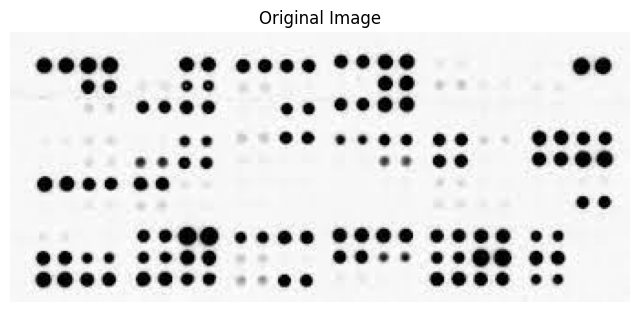

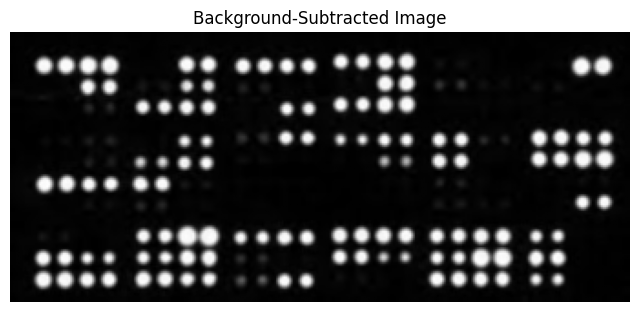

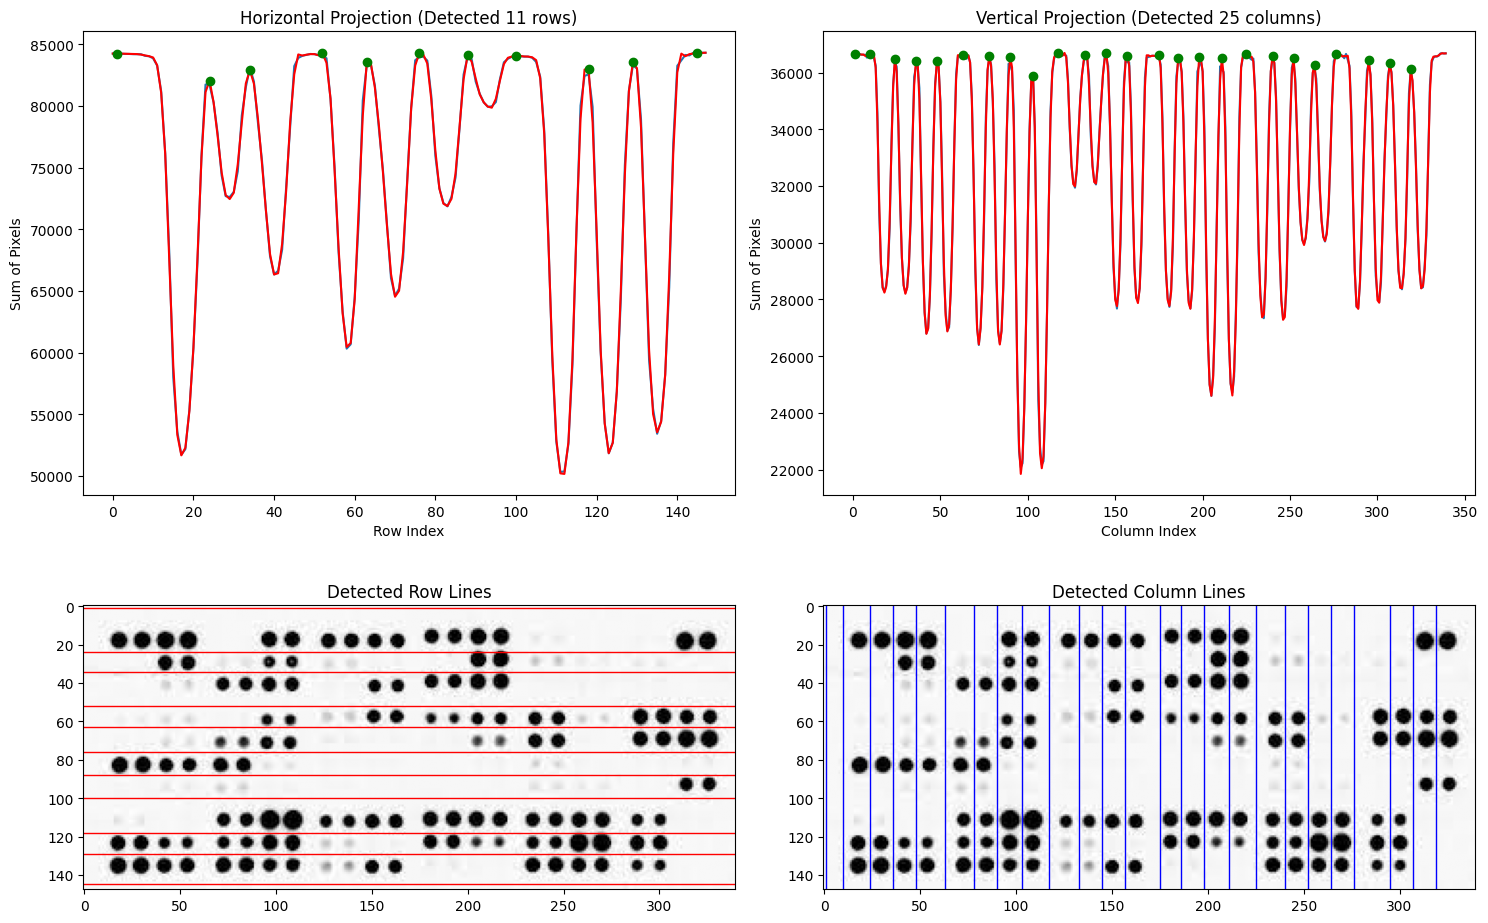

Grid structure: 11 rows x 25 columns


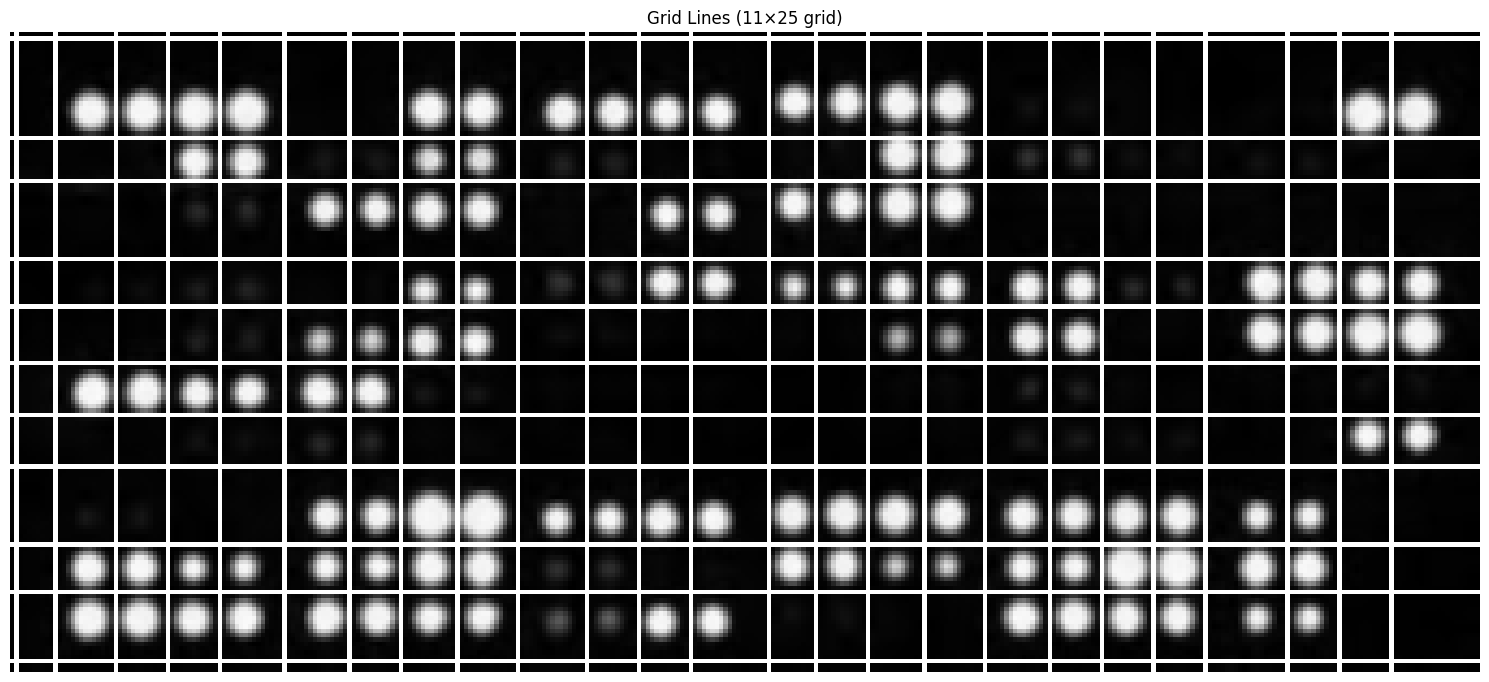

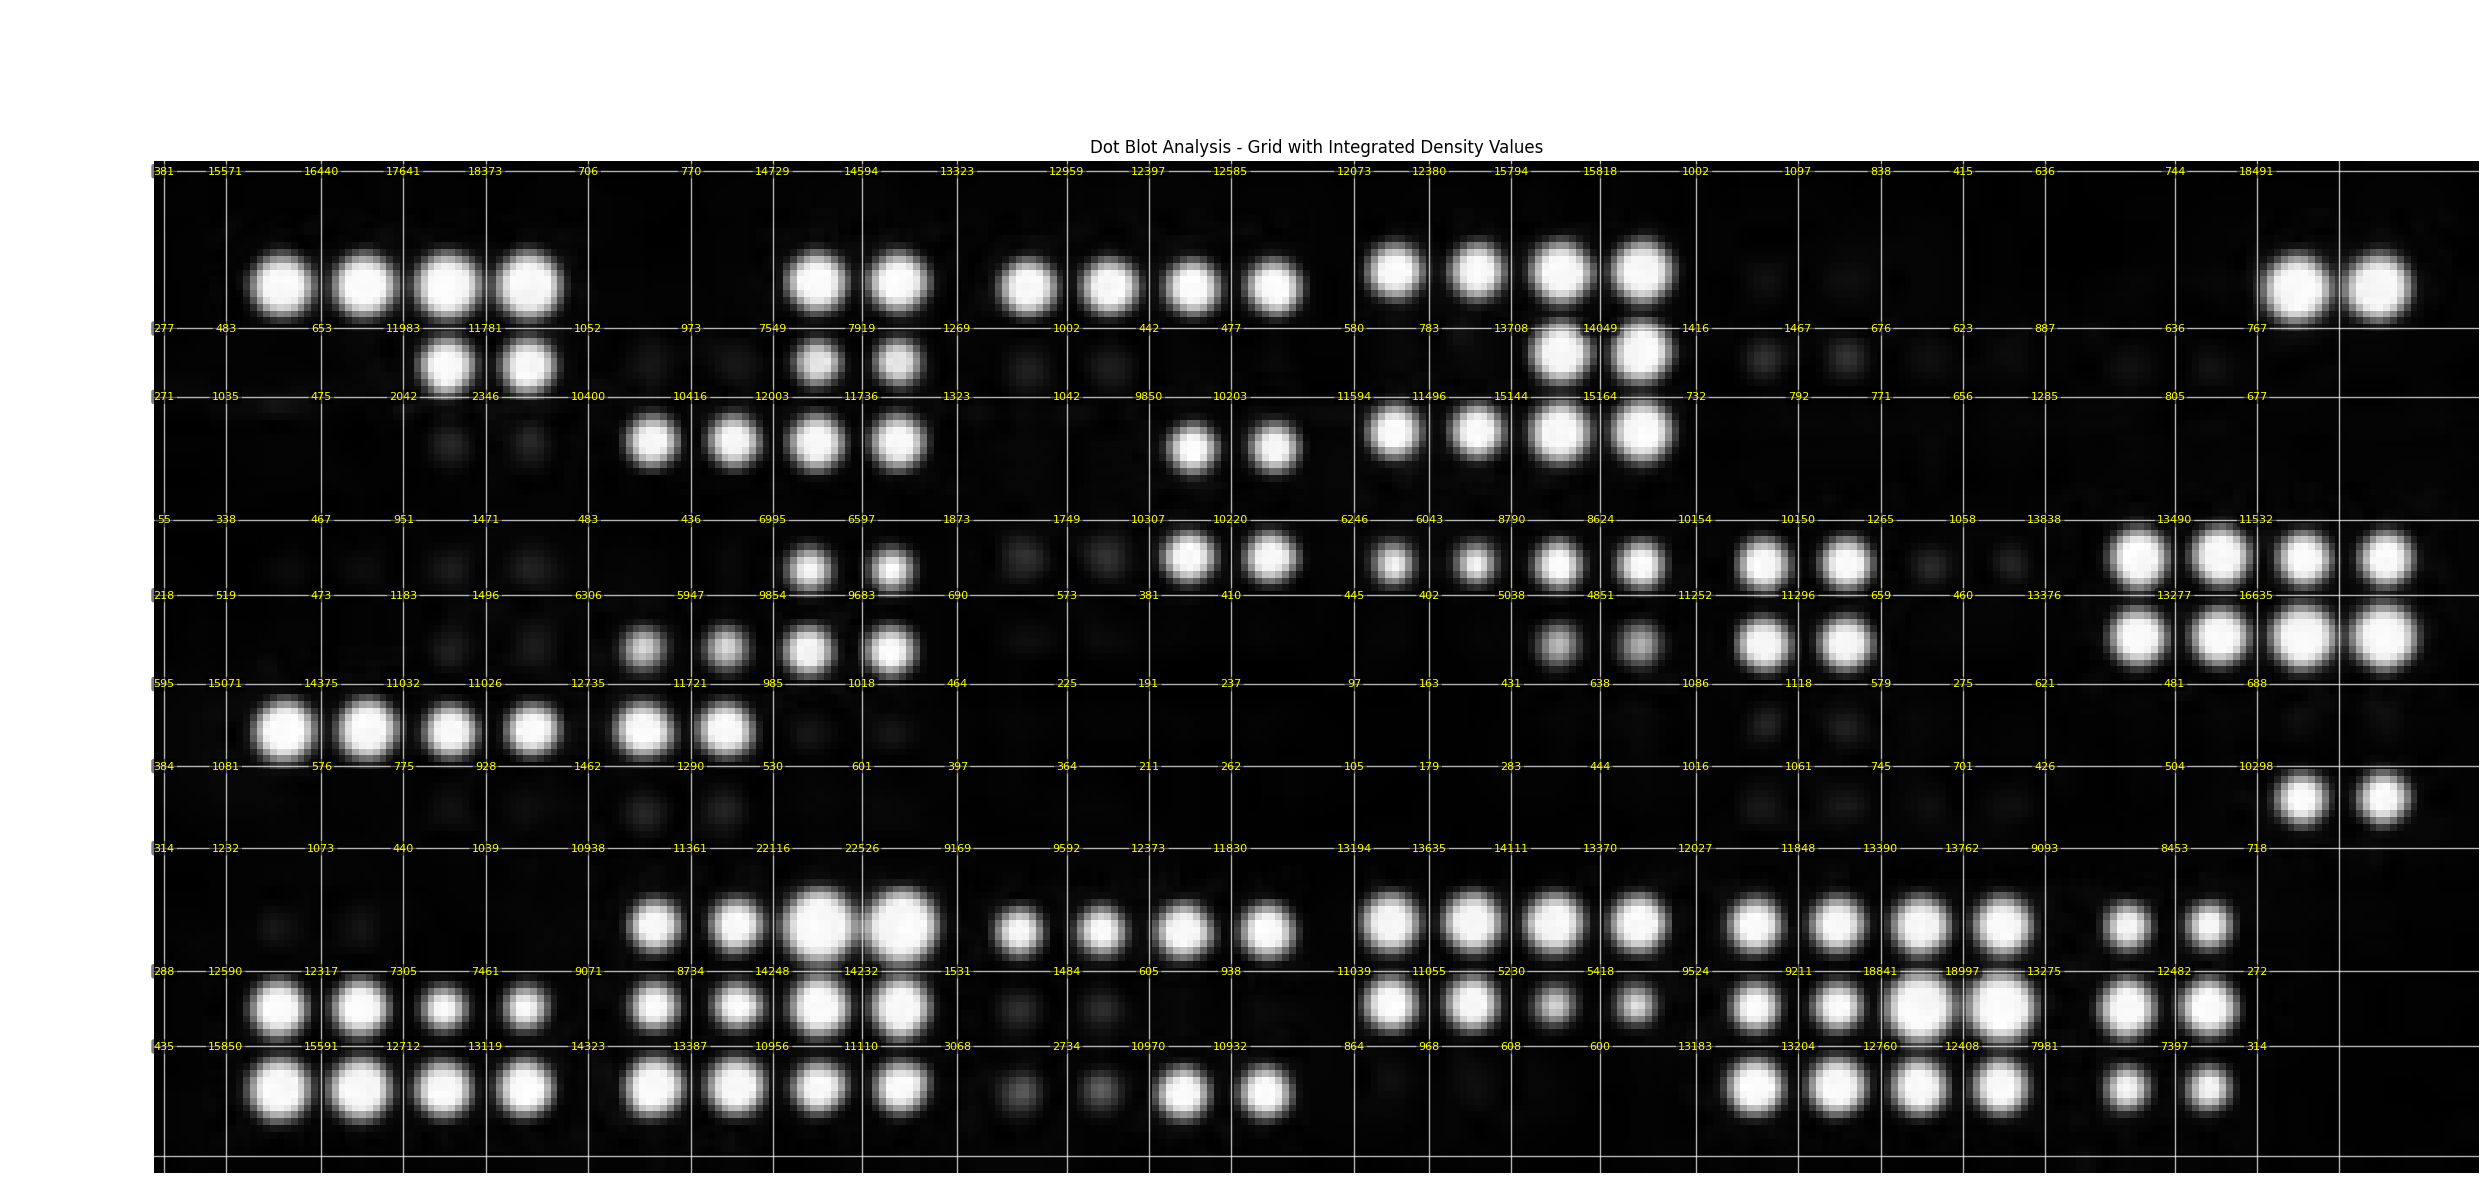

Original grid: 10 rows × 24 columns
Display grid: 10 rows × 24 columns

Cytokine Array Integrated Density Values:
----------------------------------------------------------------------------------------------------
            1       2       3       4       5       6       7       8       9      10      11      12      13      14      15      16      17      18      19      20      21      22      23      24
----------------------------------------------------------------------------------------------------
a   |      381   15571   16440   17641   18373     706     770   14729   14594   13323   12959   12397   12585   12073   12380   15794   15818    1002    1097     838     415     636     744   18491
b   |      277     483     653   11983   11781    1052     973    7549    7919    1269    1002     442     477     580     783   13708   14049    1416    1467     676     623     887     636     767
c   |      271    1035     475    2042    2346   10400   10416   12003   11736    1323  

In [ ]:
# Image path
image_path = "./test_dots.jpeg"

# Basic settings
dot_diameter = 10
expected_rows = 11  # 10 data rows + 1 border
expected_cols = 25

# Image processing settings
background_radius = 25
blur_kernel_size = (3, 3)
apply_binary_threshold=True


# Grid detection settings
min_peak_distance = 8
peak_smoothing_window = 5
regularize_grid = False

# Visualization settings
show_density_values = True
cell_opacity = 0.2
filter_borders = False
line_thickness = 1
debug_grid = True

# Run analysis
results_df = analyze_dot_blot(image_path,
                     # Basic settings
                     dot_diameter=dot_diameter,
                     expected_rows=expected_rows, 
                     expected_cols=expected_cols,
                     
                     # Image processing settings
                     background_radius=background_radius,
                     blur_kernel_size=blur_kernel_size,
                     apply_binary_threshold=apply_binary_threshold,

                     
                     # Grid detection settings
                     min_peak_distance=min_peak_distance,
                     peak_smoothing_window=peak_smoothing_window,
                     regularize_grid=regularize_grid,
                     
                     # Visualization settings
                     show_density_values=show_density_values,
    
                     line_thickness=line_thickness,
                     debug_grid=debug_grid)

print_cytokine_array_results(results_df, filter_borders=filter_borders)